In [1]:
from data_reader import DataReader
import datasets
from tweet_to_vec import TweetToVec
import utils
from LSTM import LSTMModel
from evaluate import evaluate1
from evaluate import evaluate2
import os
import matplotlib.pyplot as plt

import torch
from tqdm import tqdm
import numpy as np
from torch import nn, optim
import torch.nn as nn

In [2]:
dr = DataReader('nlkt')
dr.read_dataset(datasets.binary_classes, False)
dr.read_dataset(datasets.ternary_classes, False)
embeddings = dr.read_embeddings('embeddings/kraby.txt', False)

binary_dataset = dr.get_dataset('binary')
binary_dataset = utils.extract_validation_from_training(binary_dataset)

ternary_dataset = dr.get_dataset('ternary')
ternary_dataset = utils.extract_validation_from_training(ternary_dataset)

In [3]:
def test(dataset, epochs, method, L, size, num_layers, dropout, prediction_method, equalize_training_classes, learning_rate, number_of_output_classes):
    batch_size = 32
    t2v = TweetToVec(embeddings, method, L)

    if equalize_training_classes:
        dataset = utils.equalize_training_classes(dataset)
    vectorized_dataset = t2v.vectorize_dataset(dataset)
    def gen_batched():
        batched_dataset = t2v.batch_dataset(vectorized_dataset, batch_size, True, True)
        return batched_dataset['training tweets'], batched_dataset['training tags']

    model = LSTMModel(size=size, embedding_dim=100,num_layers=num_layers, dropout=dropout, number_of_output_classes=number_of_output_classes, L=L, prediction_method=prediction_method, learning_rate=learning_rate)

    batched = t2v.batch_dataset(vectorized_dataset, batch_size, True, False)
    tweets = batched['validation tweets']
    tags = batched['validation tags']
    current_best_score = 0
    best_model_path = ""
    params_string = f'_number_of_output_classes_{number_of_output_classes}_method_{method}_L_{L}_size_{size}_num_layers_{num_layers}_dropout_{dropout}_prediction_method_{prediction_method}_equalize_training_classes_{equalize_training_classes}_learnig_rate_{learning_rate}'
    
    scores = []

    for i in range(epochs):
        model.train_model(gen_batched, 1)
        model.eval()
        predictions = model.predict(tweets)
        score = 0
        if number_of_output_classes == 2:
            score = evaluate1(predictions, tags)['balancedf']
            print(" balancedf score on valid =", score)
        else:
            score = evaluate2(predictions, tags)['microAverageFscore']
            print(" microAverageFscore score on valid =", score)  
        scores.append(score)  
        if score > current_best_score:
            if len(best_model_path) > 0:
                os.remove(best_model_path)
            current_best_score = score
            str_score = str(score * 100)
            str_score = str_score[:min(len(str_score), 5)]
            best_model_path = 'models/LSTM_' + str_score + params_string + '.model'
            torch.save(model.state_dict(), best_model_path)
    

    plt.plot(scores)
    plt.ylabel('scores on validation over epochs')
    plt.show()
    print("Best score = ", current_best_score)

In [4]:
def evaluate_on_test(filename, dataset, size, num_layers, dropout, L, prediction_method, method, number_of_output_classes):
    model = LSTMModel(size=size, embedding_dim=100,num_layers=num_layers, dropout=dropout, number_of_output_classes=number_of_output_classes, L=L, prediction_method=prediction_method, learning_rate=0.0001)
    model.load_state_dict(torch.load(filename))
    model.eval()

    t2v = TweetToVec(embeddings, method, L)
    
    vectorized_dataset = t2v.vectorize_dataset(dataset)

    batched = t2v.batch_dataset(vectorized_dataset, 1, True, False)
    tweets = batched['test tweets']
    tags = batched['test tags']

    predictions = model.predict(tweets)
    if number_of_output_classes == 2:
        score = evaluate1(predictions, tags)['balancedf']
        print(" balancedf score on test =", score)
    else:
        score = evaluate2(predictions, tags)['microAverageFscore']
        print(" microAverageFscore score on test =", score)

## Hyperparameters turning of LSTM on binary problem

### First round of hyperparameters turning

After epoch 0 tot_loss = 317.1031799316406 balancedf score on valid = 0.39333333333333337
After epoch 1 tot_loss = 223.76597595214844 balancedf score on valid = 0.43771043771043777
After epoch 2 tot_loss = 200.2786102294922 balancedf score on valid = 0.45138888888888884
After epoch 3 tot_loss = 183.3766326904297 balancedf score on valid = 0.44370860927152317
After epoch 4 tot_loss = 167.28201293945312 balancedf score on valid = 0.40571428571428564
After epoch 5 tot_loss = 154.7316436767578 balancedf score on valid = 0.42675159235668797
After epoch 6 tot_loss = 143.69564819335938 balancedf score on valid = 0.47808764940239046
After epoch 7 tot_loss = 134.38648986816406 balancedf score on valid = 0.4873949579831932
After epoch 8 tot_loss = 124.61174774169922 balancedf score on valid = 0.44055944055944063
After epoch 9 tot_loss = 117.22840881347656 balancedf score on valid = 0.4415584415584416
After epoch 10 tot_loss = 109.84550476074219 balancedf score on valid = 0.44055944055944063
Afte

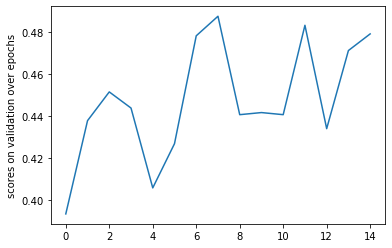

Best score =  0.4873949579831932


In [5]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=256, 
     num_layers=3, 
     dropout=0.2, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.0001,
     number_of_output_classes=2)

After epoch 0 tot_loss = 359.0401916503906 balancedf score on valid = 0.17647058823529413
After epoch 1 tot_loss = 354.8841552734375 balancedf score on valid = 0.347107438016529
After epoch 2 tot_loss = 263.63323974609375 balancedf score on valid = 0.4024767801857585
After epoch 3 tot_loss = 242.0213165283203 balancedf score on valid = 0.37823834196891193
After epoch 4 tot_loss = 231.7533721923828 balancedf score on valid = 0.4044943820224719
After epoch 5 tot_loss = 224.31802368164062 balancedf score on valid = 0.38987341772151896
After epoch 6 tot_loss = 218.5948028564453 balancedf score on valid = 0.40314136125654454
After epoch 7 tot_loss = 215.7225799560547 balancedf score on valid = 0.3969072164948454
After epoch 8 tot_loss = 209.72393798828125 balancedf score on valid = 0.4228571428571428
After epoch 9 tot_loss = 205.73538208007812 balancedf score on valid = 0.39588688946015427
After epoch 10 tot_loss = 201.79603576660156 balancedf score on valid = 0.4166666666666667
After epoch

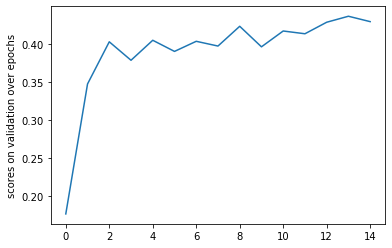

Best score =  0.4360465116279069


In [6]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d',
     L=30, 
     size=128, 
     num_layers=3, 
     dropout=0.5, 
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.0001, 
     number_of_output_classes=2)

After epoch 0 tot_loss = 224.68899536132812 balancedf score on valid = 0.4012345679012346
After epoch 1 tot_loss = 153.9773406982422 balancedf score on valid = 0.45985401459854014
After epoch 2 tot_loss = 115.5753173828125 balancedf score on valid = 0.48221343873517786
After epoch 3 tot_loss = 91.87940216064453 balancedf score on valid = 0.4510638297872341
After epoch 4 tot_loss = 74.41568756103516 balancedf score on valid = 0.4579439252336448
After epoch 5 tot_loss = 63.437049865722656 balancedf score on valid = 0.49756097560975615
After epoch 6 tot_loss = 53.97417068481445 balancedf score on valid = 0.4854368932038835
After epoch 7 tot_loss = 47.12282943725586 balancedf score on valid = 0.4639175257731959
After epoch 8 tot_loss = 39.48735809326172 balancedf score on valid = 0.47474747474747475
After epoch 9 tot_loss = 37.76483154296875 balancedf score on valid = 0.48936170212765956
After epoch 10 tot_loss = 33.73222732543945 balancedf score on valid = 0.4729064039408867
After epoch 1

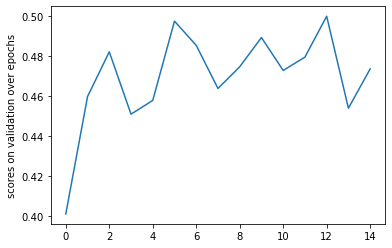

Best score =  0.5


In [7]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=256, 
     num_layers=2, 
     dropout=0.2, 
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.001, 
     number_of_output_classes=2)

After epoch 0 tot_loss = 351.11083984375 balancedf score on valid = 0.3666666666666667
After epoch 1 tot_loss = 266.0603942871094 balancedf score on valid = 0.34625322997416025
After epoch 2 tot_loss = 228.5874786376953 balancedf score on valid = 0.41042345276872966
After epoch 3 tot_loss = 213.97438049316406 balancedf score on valid = 0.4428044280442805
After epoch 4 tot_loss = 203.61810302734375 balancedf score on valid = 0.4336569579288026
After epoch 5 tot_loss = 197.43565368652344 balancedf score on valid = 0.44827586206896547
After epoch 6 tot_loss = 191.05055236816406 balancedf score on valid = 0.43853820598006643
After epoch 7 tot_loss = 184.49298095703125 balancedf score on valid = 0.426332288401254
After epoch 8 tot_loss = 178.10433959960938 balancedf score on valid = 0.43421052631578944
After epoch 9 tot_loss = 174.03225708007812 balancedf score on valid = 0.4705882352941177
After epoch 10 tot_loss = 169.37567138671875 balancedf score on valid = 0.435374149659864
After epoch

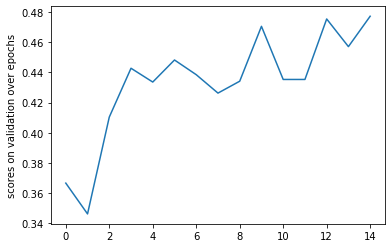

Best score =  0.47727272727272735


In [11]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=128,
     num_layers=2, 
     dropout=0.5, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.0001, 
     number_of_output_classes=2)

Last model was learning steadily and achieved a very nice score. The rest seemed to be randomly increasing and decreasing the result. We know that the loss is not compatible with the score we want to minimize, thus minimal loss doesn't mean everything to us.

### Second iterations round (small changed of the best from the previous round)

After epoch 0 tot_loss = 347.8974609375 balancedf score on valid = 0.3571428571428572
After epoch 1 tot_loss = 251.22357177734375 balancedf score on valid = 0.39296187683284456
After epoch 2 tot_loss = 224.8369140625 balancedf score on valid = 0.39118457300275483
After epoch 3 tot_loss = 214.1550750732422 balancedf score on valid = 0.40816326530612246
After epoch 4 tot_loss = 203.2179718017578 balancedf score on valid = 0.404432132963989
After epoch 5 tot_loss = 194.88876342773438 balancedf score on valid = 0.42367601246105924
After epoch 6 tot_loss = 185.6334228515625 balancedf score on valid = 0.42261904761904756
After epoch 7 tot_loss = 179.24566650390625 balancedf score on valid = 0.4390243902439024


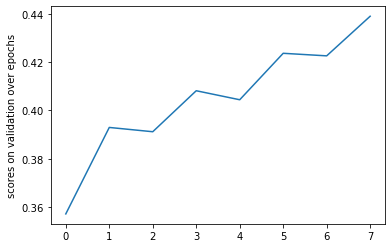

Best score =  0.4390243902439024


In [12]:
test(dataset=binary_dataset, 
     epochs=8,
     method='fixed_length_2d', 
     L=30, 
     size=128, 
     num_layers=2, 
     dropout=0.2, 
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.0001, 
     number_of_output_classes=2)

After epoch 0 tot_loss = 230.15264892578125 balancedf score on valid = 0.4305555555555556
After epoch 1 tot_loss = 151.30160522460938 balancedf score on valid = 0.4726027397260274
After epoch 2 tot_loss = 109.55432891845703 balancedf score on valid = 0.4632352941176471
After epoch 3 tot_loss = 89.16080474853516 balancedf score on valid = 0.4549763033175355
After epoch 4 tot_loss = 73.51494598388672 balancedf score on valid = 0.4833333333333334
After epoch 5 tot_loss = 62.57950973510742 balancedf score on valid = 0.45814977973568277
After epoch 6 tot_loss = 51.163089752197266 balancedf score on valid = 0.49056603773584895
After epoch 7 tot_loss = 46.3897590637207 balancedf score on valid = 0.4867724867724868


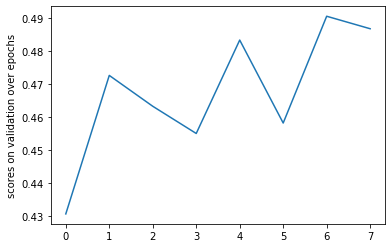

Best score =  0.49056603773584895


In [14]:
test(dataset=binary_dataset, 
     epochs=8,
     method='fixed_length_2d', 
     L=30, 
     size=256, 
     num_layers=2, 
     dropout=0.2, 
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.001, 
     number_of_output_classes=2)

After epoch 0 tot_loss = 255.33763122558594 balancedf score on valid = 0.459546925566343
After epoch 1 tot_loss = 180.1970977783203 balancedf score on valid = 0.4620462046204621
After epoch 2 tot_loss = 149.6790008544922 balancedf score on valid = 0.4581818181818182
After epoch 3 tot_loss = 129.86936950683594 balancedf score on valid = 0.4765342960288809
After epoch 4 tot_loss = 117.10810089111328 balancedf score on valid = 0.4938271604938271
After epoch 5 tot_loss = 104.11860656738281 balancedf score on valid = 0.4800000000000001
After epoch 6 tot_loss = 96.0296859741211 balancedf score on valid = 0.504424778761062
After epoch 7 tot_loss = 86.19800567626953 balancedf score on valid = 0.49372384937238484


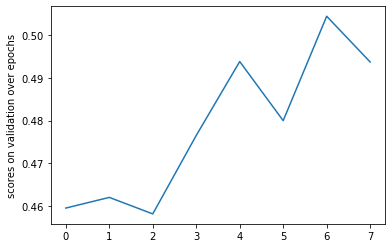

Best score =  0.504424778761062


In [15]:
test(dataset=binary_dataset, 
     epochs=8,
     method='fixed_length_2d', 
     L=30, 
     size=128, 
     num_layers=2, 
     dropout=0.5, 
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.001, 
     number_of_output_classes=2)

After epoch 0 tot_loss = 261.15765380859375 balancedf score on valid = 0.4444444444444444
After epoch 1 tot_loss = 210.65988159179688 balancedf score on valid = 0.4765625000000001
After epoch 2 tot_loss = 192.17465209960938 balancedf score on valid = 0.43421052631578944
After epoch 3 tot_loss = 176.73191833496094 balancedf score on valid = 0.4609929078014185
After epoch 4 tot_loss = 162.65109252929688 balancedf score on valid = 0.46794871794871806
After epoch 5 tot_loss = 153.82611083984375 balancedf score on valid = 0.49350649350649345
After epoch 6 tot_loss = 143.63233947753906 balancedf score on valid = 0.5206611570247934
After epoch 7 tot_loss = 138.17791748046875 balancedf score on valid = 0.5041322314049588


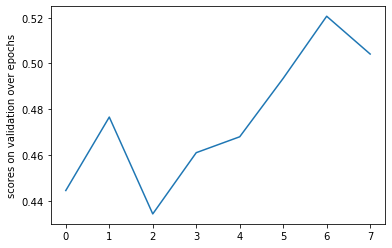

Best score =  0.5206611570247934


In [16]:
test(dataset=binary_dataset, 
     epochs=8,
     method='fixed_length_2d', 
     L=30, 
     size=128,
     num_layers=2, 
     dropout=0.8, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.001, 
     number_of_output_classes=2)

After epoch 0 tot_loss = 359.18414306640625 balancedf score on valid = 0.0
After epoch 1 tot_loss = 359.1593933105469 balancedf score on valid = 0.0
After epoch 2 tot_loss = 359.1122741699219 balancedf score on valid = 0.0
After epoch 3 tot_loss = 359.1075744628906 balancedf score on valid = 0.16453382084095067
After epoch 4 tot_loss = 359.1016845703125 balancedf score on valid = 0.16453382084095067
After epoch 5 tot_loss = 359.10162353515625 balancedf score on valid = 0.0
After epoch 6 tot_loss = 359.1318359375 balancedf score on valid = 0.16498625114573784
After epoch 7 tot_loss = 359.0954284667969 balancedf score on valid = 0.16453382084095067


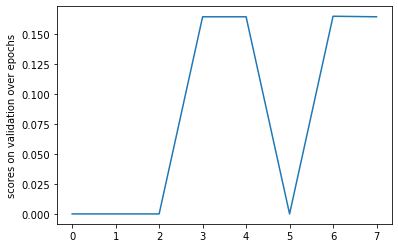

Best score =  0.16498625114573784


In [17]:
test(dataset=binary_dataset, 
     epochs=8,
     method='fixed_length_2d', 
     L=30, 
     size=128, 
     num_layers=2, 
     dropout=0.2, 
     prediction_method='last',
     equalize_training_classes=True, 
     learning_rate=0.001, 
     number_of_output_classes=2)

After epoch 0 tot_loss = 222.58883666992188 balancedf score on valid = 0.48571428571428565
After epoch 1 tot_loss = 138.2914276123047 balancedf score on valid = 0.49350649350649345
After epoch 2 tot_loss = 93.68891143798828 balancedf score on valid = 0.4835164835164835
After epoch 3 tot_loss = 68.80006408691406 balancedf score on valid = 0.45674740484429066
After epoch 4 tot_loss = 51.28188705444336 balancedf score on valid = 0.4972375690607735
After epoch 5 tot_loss = 41.54513931274414 balancedf score on valid = 0.5164835164835165
After epoch 6 tot_loss = 32.956634521484375 balancedf score on valid = 0.517766497461929
After epoch 7 tot_loss = 24.084461212158203 balancedf score on valid = 0.48863636363636365


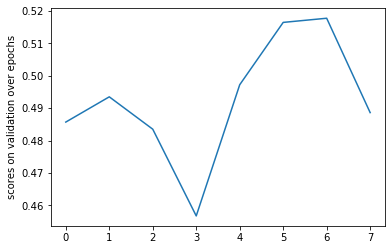

Best score =  0.517766497461929


In [20]:
test(dataset=binary_dataset, 
     epochs=8,
     method='fixed_length_2d', 
     L=30, 
     size=128, 
     num_layers=2, 
     dropout=0.2, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.001, 
     number_of_output_classes=2)

After epoch 0 tot_loss = 243.99122619628906 balancedf score on valid = 0.4
After epoch 1 tot_loss = 153.26673889160156 balancedf score on valid = 0.47619047619047616
After epoch 2 tot_loss = 114.89849853515625 balancedf score on valid = 0.4854368932038835
After epoch 3 tot_loss = 95.583984375 balancedf score on valid = 0.46511627906976744
After epoch 4 tot_loss = 79.20281219482422 balancedf score on valid = 0.4426877470355731
After epoch 5 tot_loss = 70.0118408203125 balancedf score on valid = 0.4573991031390135
After epoch 6 tot_loss = 60.531070709228516 balancedf score on valid = 0.4675324675324675
After epoch 7 tot_loss = 55.825401306152344 balancedf score on valid = 0.4615384615384615


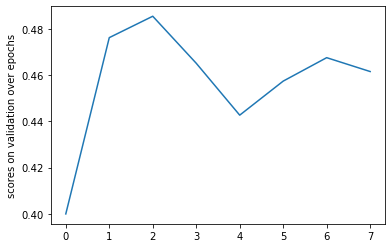

Best score =  0.4854368932038835


In [21]:
test(dataset=binary_dataset, 
     epochs=8,
     method='fixed_length_2d', 
     L=30, 
     size=128, 
     num_layers=2, 
     dropout=0.2, 
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.001, 
     number_of_output_classes=2)

After epoch 0 tot_loss = 100.07306671142578 balancedf score on valid = 0.0
After epoch 1 tot_loss = 83.14671325683594 balancedf score on valid = 0.0
After epoch 2 tot_loss = 82.4769058227539 balancedf score on valid = 0.0
After epoch 3 tot_loss = 82.32845306396484 balancedf score on valid = 0.0
After epoch 4 tot_loss = 81.9371566772461 balancedf score on valid = 0.0
After epoch 5 tot_loss = 81.7158432006836 balancedf score on valid = 0.0
After epoch 6 tot_loss = 80.82654571533203 balancedf score on valid = 0.0
After epoch 7 tot_loss = 78.38490295410156 balancedf score on valid = 0.0


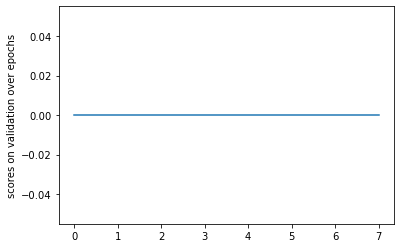

Best score =  0


In [22]:
test(dataset=binary_dataset, 
     epochs=8,
     method='fixed_length_2d', 
     L=30, 
     size=128, 
     num_layers=2, 
     dropout=0.2, 
     prediction_method='max',
     equalize_training_classes=False, 
     learning_rate=0.0001, 
     number_of_output_classes=2)

### Evaluation of the best LSTM model on binary problem

In [19]:
evaluate_on_test('models/LSTM_52.06_number_of_output_classes_2_method_fixed_length_2d_L_30_size_128_num_layers_2_dropout_0.8_prediction_method_sum_equalize_training_classes_True_learnig_rate_0.001.model',
                 dataset=binary_dataset,
                 size=128,
                 num_layers=2,
                 dropout=0.8,
                 L=30,
                 prediction_method='sum',
                 method='fixed_length_2d',
                 number_of_output_classes=2)

 balancedf score on test = 0.6289752650176679


## Hyperparameters turning of LSTM on ternary problem

### First tryouts based on best models from the binary problem

After epoch 0 tot_loss = 837.2760009765625 microAverageFscore score on valid = 0.8247011952191236
After epoch 1 tot_loss = 671.5625610351562 microAverageFscore score on valid = 0.7848605577689244
After epoch 2 tot_loss = 581.0748291015625 microAverageFscore score on valid = 0.7778884462151394
After epoch 3 tot_loss = 524.3452758789062 microAverageFscore score on valid = 0.7659362549800797
After epoch 4 tot_loss = 479.8558349609375 microAverageFscore score on valid = 0.7719123505976095


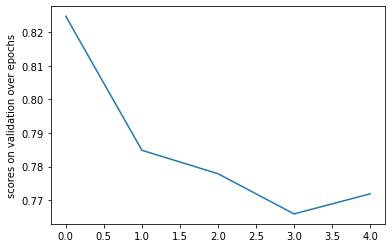

Best score =  0.8247011952191236


In [5]:
test(dataset=ternary_dataset, 
     epochs=5,
     method='fixed_length_2d', 
     L=30, 
     size=128,
     num_layers=2, 
     dropout=0.5, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.0001, 
     number_of_output_classes=3)

After epoch 0 tot_loss = 587.2269287109375 microAverageFscore score on valid = 0.6882470119521913
After epoch 1 tot_loss = 224.1399688720703 microAverageFscore score on valid = 0.8396414342629482
After epoch 2 tot_loss = 122.11113739013672 microAverageFscore score on valid = 0.8824701195219125
After epoch 3 tot_loss = 84.4664535522461 microAverageFscore score on valid = 0.8406374501992032
After epoch 4 tot_loss = 62.7370491027832 microAverageFscore score on valid = 0.9053784860557769


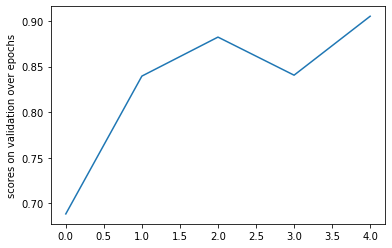

Best score =  0.9053784860557769


In [7]:
test(dataset=ternary_dataset, 
     epochs=5,
     method='fixed_length_2d', 
     L=30, 
     size=256,
     num_layers=3, 
     dropout=0.2, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.0005, 
     number_of_output_classes=3)

After epoch 0 tot_loss = 635.5595703125 microAverageFscore score on valid = 0.7679282868525896
After epoch 1 tot_loss = 325.1378173828125 microAverageFscore score on valid = 0.7818725099601593
After epoch 2 tot_loss = 231.57606506347656 microAverageFscore score on valid = 0.8227091633466136
After epoch 3 tot_loss = 190.07925415039062 microAverageFscore score on valid = 0.8595617529880478
After epoch 4 tot_loss = 163.16123962402344 microAverageFscore score on valid = 0.8575697211155379


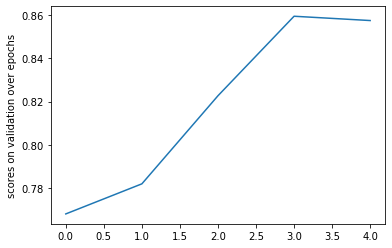

Best score =  0.8595617529880478


In [11]:
test(dataset=ternary_dataset, 
     epochs=5,
     method='fixed_length_2d', 
     L=30, 
     size=128,
     num_layers=3, 
     dropout=0.2, 
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.001, 
     number_of_output_classes=3)

### Second iteration

After epoch 0 tot_loss = 484.4403991699219 microAverageFscore score on valid = 0.7539840637450199
After epoch 1 tot_loss = 161.79165649414062 microAverageFscore score on valid = 0.8635458167330677
After epoch 2 tot_loss = 90.1431884765625 microAverageFscore score on valid = 0.8824701195219125
After epoch 3 tot_loss = 62.85580062866211 microAverageFscore score on valid = 0.8944223107569721
After epoch 4 tot_loss = 43.40291213989258 microAverageFscore score on valid = 0.8764940239043825
After epoch 5 tot_loss = 35.43889236450195 microAverageFscore score on valid = 0.8645418326693227
After epoch 6 tot_loss = 28.966625213623047 microAverageFscore score on valid = 0.8934262948207171
After epoch 7 tot_loss = 24.605390548706055 microAverageFscore score on valid = 0.8914342629482072
After epoch 8 tot_loss = 18.263721466064453 microAverageFscore score on valid = 0.9043824701195219
After epoch 9 tot_loss = 20.046873092651367 microAverageFscore score on valid = 0.8854581673306774


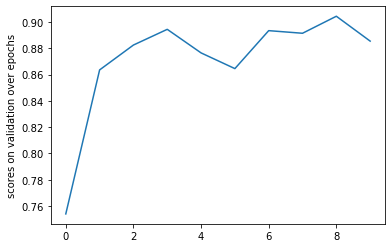

Best score =  0.9043824701195219


In [5]:
test(dataset=ternary_dataset, 
     epochs=10,
     method='fixed_length_2d', 
     L=30, 
     size=256,
     num_layers=3, 
     dropout=0.2, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.001, 
     number_of_output_classes=3)

After epoch 0 tot_loss = 738.8970947265625 microAverageFscore score on valid = 0.6384462151394422
After epoch 1 tot_loss = 392.17974853515625 microAverageFscore score on valid = 0.7659362549800797
After epoch 2 tot_loss = 246.16690063476562 microAverageFscore score on valid = 0.7798804780876495
After epoch 3 tot_loss = 189.71128845214844 microAverageFscore score on valid = 0.8057768924302788
After epoch 4 tot_loss = 150.0403289794922 microAverageFscore score on valid = 0.8107569721115537
After epoch 5 tot_loss = 133.0030517578125 microAverageFscore score on valid = 0.8247011952191236
After epoch 6 tot_loss = 114.74102783203125 microAverageFscore score on valid = 0.8356573705179283
After epoch 7 tot_loss = 105.03160095214844 microAverageFscore score on valid = 0.8386454183266933
After epoch 8 tot_loss = 92.24360656738281 microAverageFscore score on valid = 0.8356573705179283
After epoch 9 tot_loss = 85.9554214477539 microAverageFscore score on valid = 0.850597609561753


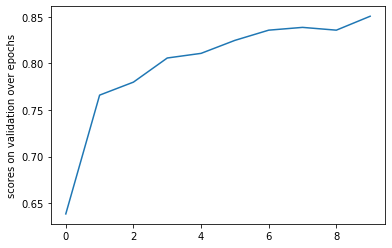

Best score =  0.850597609561753


In [6]:
test(dataset=ternary_dataset, 
     epochs=10,
     method='fixed_length_2d', 
     L=30, 
     size=256,
     num_layers=3, 
     dropout=0.2, 
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.0005, 
     number_of_output_classes=3)

### Evaluation of the best LSTM model on ternary problem

In [10]:
evaluate_on_test('models/LSTM_90.53_number_of_output_classes_3_method_fixed_length_2d_L_30_size_256_num_layers_3_dropout_0.2_prediction_method_sum_equalize_training_classes_True_learnig_rate_0.0005.model',
                 dataset=ternary_dataset,
                 size=256,
                 num_layers=3,
                 dropout=0.2,
                 L=30,
                 prediction_method='sum',
                 method='fixed_length_2d',
                 number_of_output_classes=3)

 microAverageFscore score on test = 0.881


In [7]:
evaluate_on_test('models/LSTM_90.43_number_of_output_classes_3_method_fixed_length_2d_L_30_size_256_num_layers_3_dropout_0.2_prediction_method_sum_equalize_training_classes_True_learnig_rate_0.001.model',
                 dataset=ternary_dataset,
                 size=256,
                 num_layers=3,
                 dropout=0.2,
                 L=30,
                 prediction_method='sum',
                 method='fixed_length_2d',
                 number_of_output_classes=3)

 microAverageFscore score on test = 0.891
